# Exploring GTFS files

GTFS references:

[Google Transit documentation](https://developers.google.com/transit/gtfs/reference)

[General documentation](https://gtfs.org/schedule/reference/)

In [122]:
# initialisation...

# basic modules
import numpy as np
import pandas as pd
import datetime as dt

# statistics
import statsmodels.api as sm

# dataviz
import matplotlib
from matplotlib import pyplot as plt

# spatial reference
import geopandas as gpd
import pandana as pdna

# additional GIS
import contextily as cx
from pandana.loaders import osm
from tobler.util import h3fy

In [2]:
# quality of life
import time # timers for knowing how long this entire code and some snippets take to run

code_start = time.time()

import winsound # sound alarms for long codes/snippets
import warnings # switches for optional error messages and warnings

import sys # infers allocated memory

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [3]:
# custom function to convert timestamps, as the dataset has a format that exceeds midnight

def convert_to_timedelta(time_str):
    try:
        # Split the time string into hours, minutes, and seconds to handle hours greater than 23 by converting excess hours into days
        hours, minutes, seconds = map(int, time_str.split(':'))
        days, hours = divmod(hours, 24)
        return dt.timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    except:
        return pd.NaT

## Checking raw data

First, let's the check data from [London GTFS](https://gtfs.pro/en/uk/Department-for-Transport-UK/london-dft).

In [4]:
pd.read_csv("data/london_gtfs/routes.txt", low_memory=False).sample(2)

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order,continuous_pickup,continuous_drop_off
276,2450-71792,2450-OP3039,N97,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
229,2450-84287,2450-OP3039,170,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pd.read_csv("data/london_gtfs/trips.txt", low_memory=False).sample(2)

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
50853,2450-90771,2450-132,2450-316febc2284d79dba0d6,Streatham Hill,NaN,NaN,NaN,NaN,1,NaN
318098,2450-289,2450-526,2450-798eed5c3f656ac25193,Lakeside,NaN,NaN,NaN,NaN,0,NaN


In [6]:
pd.read_csv("data/london_gtfs/stops.txt", low_memory=False).sample(2)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_desc,stop_timezone,wheelchair_boarding,level_id,platform_code
10021,2450-490006040N,57170,Denmark Street (E13),51.520036,0.024217,NaN,NaN,0,NaN,->N,NaN,1,NaN,NaN
3573,2450-40004406973A,surgtjpj,Riverside Place,51.457971,-0.476392,NaN,NaN,0,NaN,opp,NaN,0,NaN,NaN


In [7]:
pd.read_csv("data/london_gtfs/stop_times.txt", low_memory=False).sample(2)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint
7497487,2450-e7212241d5dd36f68bd0,13:35:00,13:35:00,2450-490008525BG,7,NaN,0,0,NaN,NaN,NaN,1
8045073,2450-67dc1157c3d6922cc60e,23:19:42,23:19:42,2450-490008853W,7,NaN,0,0,NaN,NaN,NaN,1


In [8]:
pd.read_csv("data/london_gtfs/frequencies.txt", low_memory=False).sample(2)

,trip_id,start_time,end_time,headway_secs,exact_times
6,2450-a1d9361b27c426f4407d,22:25:00,23:46:00,1200,1
7,2450-5a36683b3214a0ab4d30,10:59:00,13:45:00,900,1


In [9]:
pd.read_csv("data/london_gtfs/shapes.txt", low_memory=False).sample(2)

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
31531,2450-RPSP25b3610f30e4cf1fae28b1c949190d3ec119ff48,51.096104,-2.876967,2164,221947.9
7852,2450-RPSP1c68e7e318e9d449a0643f9f99687d29dce2638d,51.353104,0.094685,202,8127.1


## Transforming raw data into Pandas data frames

Now, we can import only the useful data for our purposes.

### Data frame #1: routes

In [10]:
# creating data frame, adding useful columns, adopting shorter names

routes = pd.DataFrame()
routes["route_id"] = pd.read_csv("data/london_gtfs/routes.txt", low_memory=False)["route_id"]
routes["route_alias"] = pd.read_csv("data/london_gtfs/routes.txt", low_memory=False)["route_short_name"]

# adding transport mode data and determining explicit names
# the only GTFS standard followed by this dataset is type 200 (coaches)

routes["route_mode"] = pd.read_csv("data/london_gtfs/routes.txt", low_memory=False)["route_type"]
routes["route_mode"] = routes["route_mode"].mask(routes["route_mode"] == 0, 'tram')
routes["route_mode"] = routes["route_mode"].mask(routes["route_mode"] == 1, 'tube')
routes["route_mode"] = routes["route_mode"].mask(routes["route_mode"] == 3, 'bus')
routes["route_mode"] = routes["route_mode"].mask(routes["route_mode"] == 4, 'ferry')
routes["route_mode"] = routes["route_mode"].mask(routes["route_mode"] == 200, 'coach')

### VERY IMPORTANT: note that relevant transport modes are missing such as the overground and main line rail services
### missing data includes frequent lines such as Elizabeth and Thameslink
### lines from the tram system and the DLR are not specified either

routes.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   route_id     863 non-null    object
 1   route_alias  863 non-null    object
 2   route_mode   863 non-null    object
dtypes: object(3)
memory usage: 20.4+ KB


In [11]:
# checking for duplicates

print('number of duplicates:')
display(routes["route_alias"].count() - routes["route_alias"].nunique())
# display(np.sort(routes["route_alias"].unique()))

print('\nduplicates summary:')
display(routes[routes["route_alias"].duplicated(keep=False)].sort_values("route_alias").head(6))
print('...')
display(routes[routes["route_alias"].duplicated(keep=False)].sort_values("route_alias").tail(4))

# going back to raw data (routes.txt), most of these cases refer to more than one operator assigned for each route
# the exception is some discrepancy that occurs on "route_type" column
# the routes 757, N11, N30, and N31 have both types 3 (bus) and 200 (coach); while all other cases only have type 3 assigned to them

# first, let's drop all coach, ferry and tourist lines, as they are irrelevant to urban commuting

routes = routes[
(routes["route_mode"] != 'coach') &
(routes["route_mode"] != 'ferry') &
(routes["route_alias"] != 'London Cable Car') &
(routes["route_alias"] != 'Harry_Potter_Studios_Tour_Victoria_to_Studios') &
(routes["route_alias"] != 'Warner_Bros_Studio_Tour_The_making_of_Harry_Potter')
]

# checking the new number of duplicates

print('new number of duplicates:')
display(routes["route_alias"].count() - routes["route_alias"].nunique())

# for now, we can keep the cases where there are different operators for a while, just for the sake of indexing

number of duplicates:


23


duplicates summary:


,route_id,route_alias,route_mode
857,2450-17932,101,bus
57,2450-5561,101,bus
608,2450-5812,102,bus
819,2450-17940,102,bus
58,2450-9589,104,bus
804,2450-17651,104,bus


...


,route_id,route_alias,route_mode
369,2450-91950,S1,bus
770,2450-36340,S1,bus
150,2450-9903,S3,bus
773,2450-83376,S3,bus


new number of duplicates:


19

### Data frame #2: trips

In [12]:
trips = pd.DataFrame()
trips["route_id"] = pd.read_csv("data/london_gtfs/trips.txt", low_memory=False)["route_id"]
trips["trip_id"] = pd.read_csv("data/london_gtfs/trips.txt", low_memory=False)["trip_id"]
trips["trip_headsign"] = pd.read_csv("data/london_gtfs/trips.txt", low_memory=False)["trip_headsign"]

#trip_id values are not duplicated

display(trips.sample(5))
trips.info(show_counts=True)

,route_id,trip_id,trip_headsign
38823,2450-9275,2450-6499524374051a2db3af,White City
271815,2450-73662,2450-f3babbede423e1b36832,Elmers End
99453,2450-9678,2450-dff676038504c68b40c8,Chipping Barnet
64818,2450-59932,2450-6cd78ffef47502270d9b,Woolwich Arsenal
86103,2450-11580,2450-2bc14cf4542563c3d7e9,Bexleyheath


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332854 entries, 0 to 332853
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   route_id       332854 non-null  object
 1   trip_id        332854 non-null  object
 2   trip_headsign  332854 non-null  object
dtypes: object(3)
memory usage: 7.6+ MB


In [13]:
# assigning route information and dropping unwanted routes

trips = trips.merge(routes, on='route_id', how='inner')

display(trips.sample(5))
trips.info(show_counts=True)

,route_id,trip_id,trip_headsign,route_alias,route_mode
102763,2450-5408,2450-39e6be04490885abf690,Wood Green,230,bus
19400,2450-3289,2450-cb308fbd7d894eca20f1,Brixton,Victoria,tube
127381,2450-10023,2450-8358877a87af58d4894a,North Acton,283,bus
306457,2450-10003,2450-394e1112661e2195e7c4,Manor House,279,bus
304105,2450-10985,2450-0a5c6a33ba77c9b77470,Grange Hill,462,bus


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331012 entries, 0 to 331011
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   route_id       331012 non-null  object
 1   trip_id        331012 non-null  object
 2   trip_headsign  331012 non-null  object
 3   route_alias    331012 non-null  object
 4   route_mode     331012 non-null  object
dtypes: object(5)
memory usage: 12.6+ MB


### Data frame #3: stops

In [14]:
stops = pd.read_csv("data/london_gtfs/stops.txt", low_memory=False).iloc[:,:5]
stops.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25229 entries, 0 to 25228
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stop_id    25229 non-null  object 
 1   stop_code  23046 non-null  object 
 2   stop_name  25229 non-null  object 
 3   stop_lat   25229 non-null  float64
 4   stop_lon   25229 non-null  float64
dtypes: float64(2), object(3)
memory usage: 985.6+ KB


In [15]:
print('number of duplicates:')
display(stops["stop_code"].count() - stops["stop_code"].nunique())

print('\nduplicates summary:')
display(stops[(stops["stop_code"].duplicated(keep=False)) & (~stops["stop_code"].isna())].sort_values("stop_code").head(6))
print('...')
display(stops[(stops["stop_code"].duplicated(keep=False)) & (~stops["stop_code"].isna())].sort_values("stop_code").tail(4))

# as spatial position changes in these cases (sometimes, also names), it is implied that stop_code is just a nominal variable
# we can keep using stop_id instead

number of duplicates:


22


duplicates summary:


,stop_id,stop_code,stop_name,stop_lat,stop_lon
23190,2450-490023098N,52322,Cudham Lane Recreation Ground,51.345508,0.082384
14168,2450-490009337N,52322,Cudham Lane North,51.345365,0.082349
22060,2450-490016102,52380,Northlands Avenue,51.363314,0.081885
22793,2450-490019022E,52380,Borkwood Way,51.363228,0.082182
9812,2450-490005855C1,53148,Croydon Flyover,51.370021,-0.100016
9814,2450-490005855C15,53148,Croydon Flyover,51.371073,-0.100533


...


,stop_id,stop_code,stop_name,stop_lat,stop_lon
6170,2450-490002245Z,95558,Carlton Road Bexley Road,51.477924,0.163139
6172,2450-490002246Z,95558,Carlton Road The Quarry,51.478826,0.160028
6161,2450-490002239Z,95564,Erith Leisure Centre,51.477615,0.176403
6163,2450-490002240Z,95564,Avenue Road Erith,51.475576,0.170488


### Data frame #4: stop_times
Associating stops with route information

In [16]:
stop_times = pd.read_csv("data/london_gtfs/stop_times.txt", low_memory=False).iloc[:,:8]

display(stop_times.sample(5))
stop_times.info(show_counts=True)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type
7337511,2450-943da0171075b99292db,18:18:00,18:18:00,2450-490000027A,24,NaN,0,0
8891527,2450-52e5f31b1c63cdff0fa6,23:17:00,23:17:00,2450-490012008N,11,Chingford,0,0
5667867,2450-3d4ad227ce36ac4e1f81,07:19:23,07:19:23,2450-490009051S,18,NaN,0,0
11349593,2450-d0940b1fa2549b555daa,13:34:00,13:34:00,2450-490003505W,26,NaN,0,0
670769,2450-f3582b80caf838627a2d,19:58:00,19:58:00,2450-490012843W,5,NaN,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12782539 entries, 0 to 12782538
Data columns (total 8 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   trip_id         12782539 non-null  object
 1   arrival_time    12782539 non-null  object
 2   departure_time  12782539 non-null  object
 3   stop_id         12782539 non-null  object
 4   stop_sequence   12782539 non-null  int64 
 5   stop_headsign   46407 non-null     object
 6   pickup_type     12782539 non-null  int64 
 7   drop_off_type   12782539 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 780.2+ MB


In [17]:
# assigning stop information
# also assigning trip information, consequently route information (this also removes unwanted routes that were already filtered)
stop_times = stop_times.merge(stops, on='stop_id', how='left').merge(trips, on='trip_id', how='inner')

display(stop_times.sample(5))
stop_times.info(show_counts=True)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,stop_code,stop_name,stop_lat,stop_lon,route_id,trip_headsign,route_alias,route_mode
5781881,2450-fc0cf61e610e23d829b7,04:45:00,04:45:00,2450-490007527S,18,NaN,0,0,54813,Greyhound Hill,51.592212,-0.234292,2450-8272,Marble Arch,113,bus
11393976,2450-6c7fe24bd920fd6f41b3,14:04:58,14:04:58,2450-490013730T,31,NaN,0,0,77793,Tottenham High Road,51.606219,-0.064177,2450-5845,Northumberland Park,W3,bus
11210073,2450-577cf14fd17e3e9217ef,11:28:08,11:28:08,2450-490007522S,45,NaN,0,0,75191,Grenville Road,51.344435,-0.017419,2450-68660,New Addington,64,bus
3438451,2450-4b0351d07bdc2b7f01bc,12:43:00,12:43:00,2450-490004823C,16,NaN,0,0,52513,Carshalton Ponds,51.365819,-0.163601,2450-86570,Crystal Palace,157,bus
7499219,2450-c48318ccb1ef7cab8059,08:20:00,08:20:00,2450-490006076CH,6,NaN,0,0,52731,Dickenson Road (N8),51.574999,-0.121802,2450-6794,Muswell Hill,W7,bus


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12773437 entries, 0 to 12773436
Data columns (total 16 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   trip_id         12773437 non-null  object 
 1   arrival_time    12773437 non-null  object 
 2   departure_time  12773437 non-null  object 
 3   stop_id         12773437 non-null  object 
 4   stop_sequence   12773437 non-null  int64  
 5   stop_headsign   46331 non-null     object 
 6   pickup_type     12773437 non-null  int64  
 7   drop_off_type   12773437 non-null  int64  
 8   stop_code       12097054 non-null  object 
 9   stop_name       12773437 non-null  object 
 10  stop_lat        12773437 non-null  float64
 11  stop_lon        12773437 non-null  float64
 12  route_id        12773437 non-null  object 
 13  trip_headsign   12773437 non-null  object 
 14  route_alias     12773437 non-null  object 
 15  route_mode      12773437 non-null  object 
dtypes: float64(2), i

In [18]:
# converting time columns to datetime data types to be more efficient than strings
### note: see initialisation to see the custom function used for conversion

stop_times['arrival_time'] = stop_times['arrival_time'].apply(convert_to_timedelta)
stop_times['departure_time'] = stop_times['departure_time'].apply(convert_to_timedelta)

display(stop_times.sample(5))
stop_times.info(show_counts=True)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,stop_code,stop_name,stop_lat,stop_lon,route_id,trip_headsign,route_alias,route_mode
10490648,2450-0a53a5b1deee0af08e9a,0 days 16:51:00,0 days 16:51:00,2450-490008368S,29,NaN,0,0,71180,Sobell Centre,51.557988,-0.111914,2450-84329,Euston,253,bus
5315758,2450-0e0bbfed61fa7ad29323,0 days 18:40:00,0 days 18:40:00,2450-490015403E,22,NaN,0,0,55419,Dunkery Road Ravensworth Road,51.428782,0.050290,2450-5488,Eltham Park,126,bus
587075,2450-efbc56117a58afd7384b,0 days 22:26:00,0 days 22:26:00,2450-490000039B,0,NaN,0,1,73275,Canning Town,51.513652,0.008973,2450-9200,Ilford,147,bus
6418837,2450-f0e1a7b08cf1b3f1b53e,0 days 09:15:00,0 days 09:15:00,2450-490009463W,6,NaN,0,0,48662,Lyndale Avenue Child's Hill,51.561923,-0.202095,2450-10476,Alperton,245,bus
2472602,2450-70af76829db74d43b72d,0 days 15:59:00,0 days 15:59:00,2450-490000866Z,33,NaN,0,0,92222,Forest Hill Pools,51.436550,-0.055115,2450-56863,Peckham,197,bus


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12773437 entries, 0 to 12773436
Data columns (total 16 columns):
 #   Column          Non-Null Count     Dtype          
---  ------          --------------     -----          
 0   trip_id         12773437 non-null  object         
 1   arrival_time    12773437 non-null  timedelta64[ns]
 2   departure_time  12773437 non-null  timedelta64[ns]
 3   stop_id         12773437 non-null  object         
 4   stop_sequence   12773437 non-null  int64          
 5   stop_headsign   46331 non-null     object         
 6   pickup_type     12773437 non-null  int64          
 7   drop_off_type   12773437 non-null  int64          
 8   stop_code       12097054 non-null  object         
 9   stop_name       12773437 non-null  object         
 10  stop_lat        12773437 non-null  float64        
 11  stop_lon        12773437 non-null  float64        
 12  route_id        12773437 non-null  object         
 13  trip_headsign   12773437 non-null  objec

## Assigning frequencies to the routes

Ideally, the step below would be advisable to be adopted, but the `frequencies.txt` file lacks too much information. Let's ignore this file and try other methods.

In [19]:
# trips = trips.merge(
#     pd.read_csv("data/london_gtfs/frequencies.txt", low_memory=False)[
#     ['trip_id','headway_secs']
#     ], on='trip_id', how='left'
# ).rename(columns={'headway_secs': 'hw'})

# trips.sample(5)

### Absolute shortest waiting times

The next code estimates the maximum frequencies of each route, by calculating the minimum non-zero wait time in each stop.

The frequencies may be different for each stop, because some routes have branches not specified as a separate service (e.g. Metropolitan line).

In [20]:
# initialisation of code
stop_headways = []

# grouping routes, termini, and stops in a groupby object
for (i,j,k), group in stop_times.groupby(['route_id', 'trip_headsign', 'stop_id']):
    
    # initialisation for each route
    last_time = None
    hw_min = dt.timedelta(hours=24)
    
    for arrival in group['arrival_time'].sort_values():
        # compares the frequency in a given timestamp with the shortest waiting time until now
        if (last_time != None)&(arrival != last_time):
            hw_min = min(hw_min, arrival - last_time)
        last_time = arrival

    # adds the shortest waiting time (of a given route and terminus) to a list
    stop_headways.append([i, j, k, hw_min])
    
# after the loop, transforms the list into a dataframe
stop_headways = pd.DataFrame(stop_headways, columns=['route_id','trip_headsign','stop_id','hw_min_day'])

# this snippet took approximately 90 seconds to finish

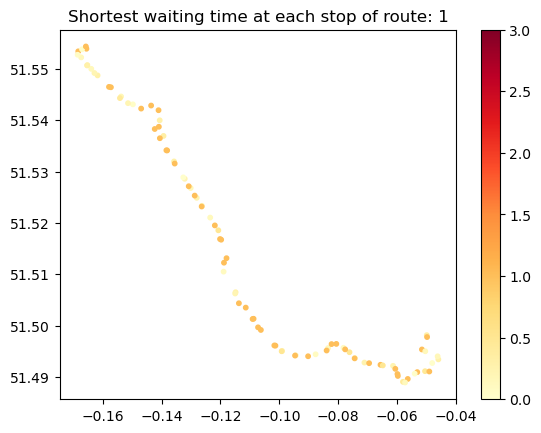

In [21]:
chosen_id = '2450-82736'

fig, ax = plt.subplots()

plt.title(f'Shortest waiting time at each stop of route: {routes[routes["route_id"] == chosen_id].iloc[0,1]}')
plt.scatter(stop_headways.merge(stops, on='stop_id', how='left')[stop_headways['route_id'] == chosen_id]['stop_lon'],
            stop_headways.merge(stops, on='stop_id', how='left')[stop_headways['route_id'] == chosen_id]['stop_lat'], 
            c=stop_headways[stop_headways['route_id'] == chosen_id].sort_values('stop_id')['hw_min_day'].apply(lambda x: x.total_seconds()/60),
            s=10,
            cmap='YlOrRd', 
            norm=matplotlib.colors.Normalize(vmin=0, vmax=3)
           )
cb = plt.colorbar()

plt.show()

In [22]:
stop_headways.sample(5)

,route_id,trip_headsign,stop_id,hw_min_day
35489,2450-53729,Uxbridge,2450-490015036L,0 days 00:01:00
9381,2450-11506,Ilford,2450-490007596K,0 days 00:01:00
46542,2450-79273,Frimley,2450-40004403101A,0 days 00:05:00
8572,2450-11394,Petts Wood,2450-490013496S,0 days 00:00:24
50987,2450-84287,Roehampton,2450-490011641C,0 days 00:01:00


### Shortest average waiting times

An alternative method is aggregating the vehicle supply in discrete groups (e.g. 1 hour) to avoid accounting for piecemeal short headways that leave holes in the schedule.

_In other words: taking the average of the headway values measured in the stops for one hour of operation may thin out these unwanted effects and show a better representation of the real operation._

Also, this may happen as a result of the documentation method; this is likely if it is based on a in situ reading, because supply fluctuation is normal in transport operation.

Thus, using this method for estimating waiting times is probably a wiser decision than making any assumptions about the data collection.

In [23]:
# initialisation of code
stop_headways = []

# grouping routes, termini, and stops in a groupby object
for (i,j,k), group in stop_times.groupby(['route_id', 'trip_headsign', 'stop_id']):
    
    # initialisation for each route
    hw_min = dt.timedelta(hours=24)
    last_arrival = None

    if (
    (group['arrival_time'].count() <= 1)
    | (group['arrival_time'].max() == dt.timedelta(0))
    ):
        stop_headways.append([i, j, k, dt.timedelta(days=1)])
    
    else:
    
        # partitioning the total timespan of operation in 24 bins, then grouping then in a groupby object
        for partition, arrival_within_partition in group.groupby(
        pd.cut(
        group['arrival_time'],
        bins=[bin*(group['arrival_time'].max()/ 24) for bin in range(25)],
        include_lowest=True
        ),observed=False):
            
            # initialisation for each partition
            headway_entries = []
            
            # lists every instance of a vehicle (of a given route and terminus) passing by the stop
            for arrival in arrival_within_partition['arrival_time'].sort_values():
                if last_time != None:
                    headway_entries.append(arrival - last_arrival)
                last_arrival = arrival
                
            # calculates the average waiting time within the partition and compares it with the other partitions
            if len(headway_entries) !=0:
                hw_min = min(hw_min, (sum(headway_entries,dt.timedelta(0))/len(headway_entries)).floor('s'))
    
        # adds the shortest waiting time (of a given route and terminus in a stop) to a list
        stop_headways.append([i, j, k, hw_min])
    
# after the whole loop, transforms the list into a dataframe
stop_headways = pd.DataFrame(stop_headways, columns=['route_id','trip_headsign','stop_id','hw_min_day'])

stop_headways.sample(5)

# this snippet took approximately 20 minutes to finish
# long procedure:
winsound.PlaySound('ding.wav', winsound.SND_FILENAME)

In [24]:
stop_times[stop_times['stop_id'] == '2450-1600GL1082'].sample(2)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,stop_code,stop_name,stop_lat,stop_lon,route_id,trip_headsign,route_alias,route_mode
12276333,2450-e170c88b396dc4fbe00b,0 days 14:05:00,0 days 14:05:00,2450-1600GL1082,3,NaN,0,0,glodtdta,Royal Well Bus Station,51.899678,-2.078013,2450-89,Victoria,444,bus
12276367,2450-2ebd05fb4de80f22ccdb,0 days 11:30:00,0 days 11:30:00,2450-1600GL1082,1,NaN,0,0,glodtdta,Royal Well Bus Station,51.899678,-2.078013,2450-89,Gloucester,444,bus


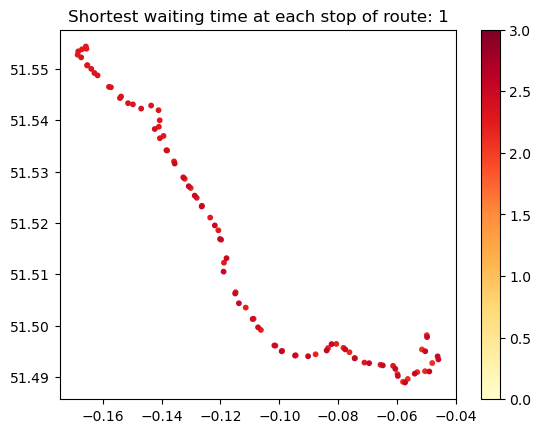

In [25]:
chosen_id = '2450-82736'

fig, ax = plt.subplots()

plt.title(f'Shortest waiting time at each stop of route: {routes[routes["route_id"] == chosen_id].iloc[0,1]}')
plt.scatter(stop_headways.merge(stops, on='stop_id', how='left')[stop_headways['route_id'] == chosen_id]['stop_lon'],
            stop_headways.merge(stops, on='stop_id', how='left')[stop_headways['route_id'] == chosen_id]['stop_lat'], 
            c=stop_headways[stop_headways['route_id'] == chosen_id]['hw_min_day'].apply(lambda x: x.total_seconds()/60),
            s=10,
            cmap='YlOrRd', 
            norm=matplotlib.colors.Normalize(vmin=0, vmax=3)
           )
cb = plt.colorbar()

plt.show()

In [26]:
stop_headways.sample(5)

,route_id,trip_headsign,stop_id,hw_min_day
18933,2450-2420,Waltham Cross,2450-490000083X,0 days 00:09:08
49008,2450-8169,Archway,2450-490009804E,0 days 00:02:25
37124,2450-57706,Heathrow Airport Terminal 5,2450-490020178N,1 days 00:00:00
51513,2450-8441,Erith,2450-490003975S,1 days 00:00:00
61527,2450-9260,Ilford,2450-490013331Z,0 days 00:04:16


## Estimating travel times by public transport

We're going to use many additional modules to calculate network travel costs: `pandana`, `geopandas` and `statsmodels`. Estimating the effects of the network topology on travel is important not only for producing time matrices essential to generate accessibility measures, but also for determining realised cruising speeds, average pickup/dropoff times, and penalties for vehicles speeding up and slowing down.

### Step #1: Determining costs by type

Travel costs can be estimated by many methods. Some are presented below.

#### Average travel times with Pandas, derived from GTFS stop times data

First, a list of unique valid links, effectively connected by the transport system, must be generated. Iteratively, the time to go between stops can also be calculated with the timestamps recorded in the GTFS file.

In [27]:
# initialising iterable variables...
stop_links_raw = []
trip_previous_step = None
previous_stop = None
last_timestamp = None

# scanning every single trip:

for index in stop_times.sort_values(by=['trip_id', 'stop_sequence']).itertuples():
    
    # associating iterable variables with current step
    trip = index.trip_id
    stop = index.stop_id
    timestamp = index.arrival_time
    
    # appending new values in each trip
    if trip == trip_previous_step:
        stop_links_raw.append([previous_stop,stop,index.route_mode,index.route_id,(timestamp-last_timestamp)])
    
    # updating iterable variables for comparison with the next step
    trip_previous_step = trip
    previous_stop = stop
    last_timestamp = index.departure_time

# this snippet took approximately 3 minutes to finish

In [28]:
# saving all the links, as shapes.txt is not a comprehensive list

stop_shapes = pd.DataFrame(stop_links_raw, columns=['stop_id_1', 'stop_id_2', 'route_mode', 'route_id', 'time_between'])

# clearing memory from temporary variable
stop_links_raw = None

In [29]:
stop_shapes.sample(5)

,stop_id_1,stop_id_2,route_mode,route_id,time_between
171099,2450-490009076E,2450-490010078J,bus,2450-90759,0 days 00:01:00
9293035,2450-490011674W,2450-490011348W,bus,2450-10098,0 days 00:01:00
7156010,2450-490013965E,2450-490013936E,bus,2450-10317,0 days 00:01:00
3203213,2450-490018714S,2450-490002039B,bus,2450-74559,0 days 00:01:00
5681535,2450-490008515C,2450-490010709N,bus,2450-85284,0 days 00:02:00


The absolute travel time values are transformed into summarised values (mean and standard deviation).

In [30]:
stop_links = stop_shapes.groupby(['stop_id_1', 'stop_id_2', 'route_mode']
                                ).agg(time_avg=('time_between', 'mean'), time_std=('time_between', 'std')
                                     ).reset_index()

# adding stop spatial information

stop_links = stop_links.merge(stops, left_on = 'stop_id_1', right_on = 'stop_id', how='left'
                              ).rename(columns={'stop_lon':'stop_lon_1','stop_lat':'stop_lat_1'}
                                      ).drop(columns=['stop_id','stop_code','stop_name']
                                            ).merge(stops, left_on = 'stop_id_2', right_on = 'stop_id', how='left'
                                                   ).rename(columns={'stop_lon':'stop_lon_2','stop_lat':'stop_lat_2'}
                                                           ).drop(columns=['stop_id','stop_code','stop_name']
                                                                 )

In [31]:
stop_links.head(3)

,stop_id_1,stop_id_2,route_mode,time_avg,time_std,stop_lat_1,stop_lon_1,stop_lat_2,stop_lon_2
0,2450-01000053221,2450-3600SOA10420,bus,0 days 01:30:00,NaT,51.458946,-2.593343,51.091767,-3.016736
1,2450-01000053221,2450-3600SOA14161,bus,0 days 01:25:00,0 days 00:05:46.410161513,51.458946,-2.593343,51.129737,-2.999606
2,2450-01000053221,2450-490014256D,bus,0 days 02:48:20,0 days 00:05:46.410161513,51.458946,-2.593343,51.493255,-0.199684


The spatial data will be converted to suitable formats to make procedures relating to estimating distances and metrics from the network.

The `geopandas` module will be employed with the classes `GeoSeries` and `GeoDataFrame`, which allow for the use of tools such as `points_from_xy` to handle coordinates and `to_crs` to convert datum references.

The geographic coordinated system used here is `EPSG:4326` (WGS84) and the projected system is `EPSG:27700` (the British National Grid).

In [32]:
# transforming coordinates to Geopandas geometry objects

stop_links['stop_pos_1'] = gpd.GeoSeries(
    gpd.points_from_xy(
        stop_links.stop_lon_1,
        stop_links.stop_lat_1),
    crs='EPSG:4326')

stop_links['stop_pos_2'] = gpd.GeoSeries(
    gpd.points_from_xy(
        stop_links.stop_lon_2,
        stop_links.stop_lat_2),
    crs='EPSG:4326')

In [33]:
# # converting to UTM datum

# stop_links['stop_pos_1'] = gpd.GeoSeries(stop_links['stop_pos_1']).to_crs(crs='EPSG:27700')
# stop_links['stop_lon_1'] = gpd.GeoSeries(stop_links['stop_pos_1']).x
# stop_links['stop_lat_1'] = gpd.GeoSeries(stop_links['stop_pos_1']).y
# stop_links['stop_pos_2'] = gpd.GeoSeries(stop_links['stop_pos_2']).to_crs(crs='EPSG:27700')
# stop_links['stop_lon_2'] = gpd.GeoSeries(stop_links['stop_pos_2']).x
# stop_links['stop_lat_2'] = gpd.GeoSeries(stop_links['stop_pos_2']).y

In [34]:
stop_links.sample(5)

,stop_id_1,stop_id_2,route_mode,time_avg,time_std,stop_lat_1,stop_lon_1,stop_lat_2,stop_lon_2,stop_pos_1,stop_pos_2
13089,2450-490006792E,2450-490012367E,bus,0 days 00:00:52.919220055,0 days 00:00:13.023169716,51.495681,-0.078243,51.494820,-0.076190,POINT (-0.07824 51.49568),POINT (-0.07619 51.49482)
19423,2450-490010852N,2450-490008306E,bus,0 days 00:00:25.477876106,0 days 00:00:03.999476323,51.561123,-0.150680,51.561861,-0.150101,POINT (-0.15068 51.56112),POINT (-0.15010 51.56186)
18510,2450-490010225N,2450-490013888N,bus,0 days 00:01:14.773584905,0 days 00:00:28.973389806,51.475685,-0.192715,51.477468,-0.192313,POINT (-0.19271 51.47568),POINT (-0.19231 51.47747)
16977,2450-490009241E,2450-490009243E,bus,0 days 00:00:47.979797979,0 days 00:00:13.894438720,51.366649,0.050401,51.366806,0.054273,POINT (0.05040 51.36665),POINT (0.05427 51.36681)
23796,2450-490013615Q,2450-490009117J,bus,0 days 00:02:05.330985915,0 days 00:00:55.293874375,51.446358,-0.022678,51.445009,-0.020563,POINT (-0.02268 51.44636),POINT (-0.02056 51.44501)


In [35]:
# EARLY DROP

stop_times = None # 7.5 GiB using custom sys function (see initialisation)
trips = None # 106.1 MiB using custom sys function (see initialisation)

#### Estimating distances

##### Network distances with Pandana, derived from GTFS shape data

Now, we can use the `shapes.txt` file to calculate the distance between each stop pair, instead of the time span needed to go between the stops.

In [36]:
# loading the network
shapes = pd.read_csv("data/london_gtfs/shapes.txt", low_memory=False)

# # transforming coordinates to Geopandas geometry objects

# shapes['shape_pt_pos'] = gpd.GeoSeries(
#     gpd.points_from_xy(
#         shapes.shape_pt_lon,
#         shapes.shape_pt_lat),
#     crs='EPSG:4326')

# # converting to UTM datum

# shapes['shape_pt_pos'] = gpd.GeoSeries(shapes['shape_pt_pos']).to_crs(crs='EPSG:27700')
# shapes['shape_pt_lon'] = gpd.GeoSeries(shapes['shape_pt_pos']).x
# shapes['shape_pt_lon'] = gpd.GeoSeries(shapes['shape_pt_pos']).y

In [37]:
# initialising iterable variables...

nodes = []
edges = []
shape_previous_step = None
last_milestone = None
node_id = 0

# scanning every single shape:

for index in shapes.sort_values(by=['shape_id', 'shape_pt_sequence']).itertuples():
    
    # associating iterable variables with current step
    node_id += 1
    shape = index.shape_id
    milestone = index.shape_dist_traveled
    nodes.append([node_id, index.shape_pt_lon, index.shape_pt_lat])
        
    # appending new values in each shape
    if shape == shape_previous_step:
        edges.append([(node_id - 1), node_id, (milestone-last_milestone)])
    
    # updating iterable variables for comparison with the next step
    shape_previous_step = shape
    last_milestone = milestone

# transforming the two lists into dataframes
nodes = pd.DataFrame(nodes, columns=['node_id','x','y'])
nodes.index = nodes['node_id']
edges = pd.DataFrame(edges, columns=['from', 'to', 'distance'])
edges.index = edges['from']

# setting up a Pandana network
shapes_network = pdna.Network(nodes['x'], nodes['y'], edges['from'], edges['to'], edges[['distance']])

# this snippet took approximately a half second to finish

In [38]:
# turning off warnings, as the data in shapes.txt is incomplete
warnings.filterwarnings('ignore')

distances = shapes_network.shortest_path_lengths(
    [o for o in shapes_network.get_node_ids(stop_links.stop_lon_1, stop_links.stop_lat_1).values],
    [d for d in shapes_network.get_node_ids(stop_links.stop_lon_2, stop_links.stop_lat_2).values])

# turning on warnings again
warnings.filterwarnings('always')

stop_links['distance'] = pd.Series(distances)

print(f'number of zero values: {len(stop_links[stop_links["distance"] == 0])}')
print(f'number of NaN values: {len(stop_links[stop_links["distance"].isna()])}')
stop_links.info()

# this snippet took less than a second to finish

number of zero values: 15037
number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29215 entries, 0 to 29214
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   stop_id_1   29215 non-null  object         
 1   stop_id_2   29215 non-null  object         
 2   route_mode  29215 non-null  object         
 3   time_avg    29215 non-null  timedelta64[ns]
 4   time_std    28789 non-null  timedelta64[ns]
 5   stop_lat_1  29215 non-null  float64        
 6   stop_lon_1  29215 non-null  float64        
 7   stop_lat_2  29215 non-null  float64        
 8   stop_lon_2  29215 non-null  float64        
 9   stop_pos_1  29215 non-null  geometry       
 10  stop_pos_2  29215 non-null  geometry       
 11  distance    29215 non-null  float64        
dtypes: float64(5), geometry(2), object(3), timedelta64[ns](2)
memory usage: 2.7+ MB


##### Euclidean distances with Geopandas

Unfortunately, as seen above, `shapes.txt` does not cover every pair of stops, so a tentative solution is calculating Euclidean distances when the shortest path algorithm from `pandana` can't estimate distances. We can use the `distance` method from `geopandas` to do that.

The result relates to a simplified version of the public transport, where the links are straight lines between stops. This can be refined later by using tags from OpenStreetMap to use actual networks (road network for buses and rail network for trains).

In [39]:
# converting to UTM datum

stop_links['stop_pos_1'] = gpd.GeoSeries(stop_links['stop_pos_1']).to_crs(crs='EPSG:27700')
stop_links['stop_lon_1'] = gpd.GeoSeries(stop_links['stop_pos_1']).x
stop_links['stop_lat_1'] = gpd.GeoSeries(stop_links['stop_pos_1']).y
stop_links['stop_pos_2'] = gpd.GeoSeries(stop_links['stop_pos_2']).to_crs(crs='EPSG:27700')
stop_links['stop_lon_2'] = gpd.GeoSeries(stop_links['stop_pos_2']).x
stop_links['stop_lat_2'] = gpd.GeoSeries(stop_links['stop_pos_2']).y

# using the Euclidean distance method
stop_links.loc[:, 'distance'] = gpd.GeoSeries(
    stop_links.loc[:, 'stop_pos_1']
).distance(
    gpd.GeoSeries(
        stop_links.loc[:, 'stop_pos_2']
    ))#.set_axis((stop_links.loc[:, 'distance']).index)

display(len(stop_links[stop_links['distance'] == 0]))
display(len(stop_links[stop_links['distance'].isna()]))
stop_links.head(10)

0

0

,stop_id_1,stop_id_2,route_mode,time_avg,time_std,stop_lat_1,stop_lon_1,stop_lat_2,stop_lon_2,stop_pos_1,stop_pos_2,distance
0,2450-01000053221,2450-3600SOA10420,bus,0 days 01:30:00,NaT,173497.190361,358873.134398,132987.662705,328892.551080,POINT (358873.134 173497.190),POINT (328892.551 132987.663),50396.996011
1,2450-01000053221,2450-3600SOA14161,bus,0 days 01:25:00,0 days 00:05:46.410161513,173497.190361,358873.134398,137193.542808,330149.563019,POINT (358873.134 173497.190),POINT (330149.563 137193.543),46292.530482
2,2450-01000053221,2450-490014256D,bus,0 days 02:48:20,0 days 00:05:46.410161513,173497.190361,358873.134398,178681.802979,525077.365809,POINT (358873.134 173497.190),POINT (525077.366 178681.803),166285.076741
3,2450-021012007,2450-02901606,bus,0 days 00:01:11,0 days 00:00:03.872983346,218653.113233,509285.339753,219748.009527,509032.325554,POINT (509285.340 218653.113),POINT (509032.326 219748.010),1123.750007
4,2450-021012008,2450-021012010,bus,0 days 00:00:23.416666666,0 days 00:00:01.443375672,218650.072927,509314.343699,218274.058704,509332.316663,POINT (509314.344 218650.073),POINT (509332.317 218274.059),376.443519
5,2450-021012009,2450-021012007,bus,0 days 00:00:27.266666666,0 days 00:00:01.032795558,218232.095125,509321.309996,218653.113233,509285.339753,POINT (509321.310 218232.095),POINT (509285.340 218653.113),422.551897
6,2450-021012010,2450-210021428151,bus,0 days 00:00:39.666666666,0 days 00:00:02.309401076,218274.058704,509332.316663,217650.070629,509469.330540,POINT (509332.317 218274.059),POINT (509469.331 217650.071),638.853598
7,2450-02900033,2450-02900061,bus,0 days 00:08:00,NaT,221587.004412,509206.325173,221327.101351,511921.376262,POINT (509206.325 221587.004),POINT (511921.376 221327.101),2727.462560
8,2450-02900033,2450-02901380,bus,0 days 00:11:00,NaT,221587.004412,509206.325173,223781.059323,510296.317448,POINT (509206.325 221587.004),POINT (510296.317 223781.059),2449.889816
9,2450-02900033,2450-02903502,bus,0 days 00:05:45,0 days 00:00:51.961524227,221587.004412,509206.325173,221265.045243,509499.323422,POINT (509206.325 221587.004),POINT (509499.323 221265.045),435.322502


#### Estimating speed values by linear regression with Statsmodels

Now, we can estimate average speeds, which are going to be useful for estimating parameters for transport operation.

In [40]:
stop_links['speed'] = pd.Series()
stop_links.loc[(stop_links['time_avg'].apply(lambda x: x.total_seconds()) !=0), 'speed'] = 3.6*(stop_links['distance']/stop_links['time_avg'].apply(lambda x: x.total_seconds()))
stop_links['speed'] = stop_links['speed'].fillna(0).astype('float64')
stop_links[['stop_id_1','stop_id_2','distance','time_avg','speed']].sort_values('speed').iloc[::-1].sample(5)

C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\1979539418.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stop_links['speed'] = stop_links['speed'].fillna(0).astype('float64')


,stop_id_1,stop_id_2,distance,time_avg,speed
22144,2450-490012606SD,2450-490001271SA,265.370060,0 days 00:01:14.071913161,12.897361
18143,2450-490009998W,2450-490012758W,306.401272,0 days 00:01:26.168478260,12.801022
17771,2450-490009776S,2450-490009770S,311.884140,0 days 00:00:57.647058823,19.476847
9418,2450-490004325W,2450-490003357N,344.793026,0 days 00:01:01.586363636,20.154704
28779,2450-9400ZZLUGTH1,2450-9400ZZLUNBP1,1739.319667,0 days 00:02:30.083565459,41.720430


Apart from flat average speeds, divided by each stretch of distance between stops, other procedures regarding speed can be made.

For example, it is likely that routes with the same transport mode will share similar speeds, because of not only technology, but also segregation from the external urban system. Some procedures can be tested, such as a scatter plot showing differences and similarities between modes.

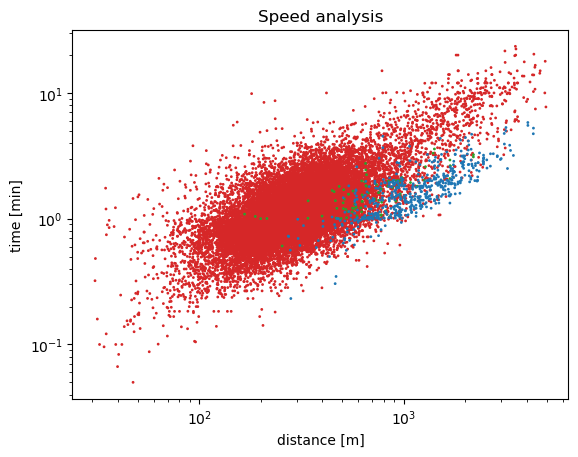

In [41]:
fig, ax = plt.subplots()

plt.xlabel("distance [m]")
plt.ylabel("time [min]")

min_dist = 30
max_dist = 5000

plt.title('Speed analysis')

# x axis: distance between stops

plt.scatter(stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1)) # controlling for biases (travel time assumed to be round numbers)
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            # &(stop_links['route_mode'] != 'bus')
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['distance'],
            
            stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            # &(stop_links['route_mode'] != 'bus')
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['time_avg'].apply(lambda x: x.total_seconds()/60),
            
            s=1,

# y axis: time between stops

            c=stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            # &(stop_links['route_mode'] != 'bus')
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['route_mode'].map({'bus':'tab:red','tube':'tab:blue','tram':'tab:green'})
            # , cmap='Set1'
            # , norm=matplotlib.colors.Normalize(vmin=0, vmax=100)
           )

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

As presented above, there is some proportional relationship between distance and time. Linear regressions are able to estimate the average speed realised by vehicles, by assuming that:

$ \bar{v} = \dfrac{s}{t} \implies t = \dfrac{1}{\bar{v}}s $

_(where: $ \bar{v} $ is the average speed, and $ s $ and $ t $ are the distance and time spans between stops)_

If a intersect is assumed in the linear regression model, it relates to general penalties ($ \pi_{0} $) for each stop, relating to external interferences and technological characteristics such as acceleration and braking capabilities of the vehicles. In this case, the speed corresponds to the average cruising speed ($ v_{max} $) instead of a more generalised average ($ \bar{v} $). The formula below represents the linear regression with an intesect:

$ t = \pi_{0} + \dfrac{1}{v_{max}}s $

The snippet below calculates the coefficients of both these linear models.

In [42]:
for i in ['tube','tram','bus']:

    # FIRST MODEL

# dependent variable: travel time
    
    speed_model = sm.OLS(stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
                &(stop_links['time_avg'] != dt.timedelta(minutes=2))
                &(stop_links['time_avg'] != dt.timedelta(minutes=3))
                &(stop_links['time_avg'] != dt.timedelta(minutes=4))
                &(stop_links['time_avg'] != dt.timedelta(minutes=5))
                &(stop_links['time_avg'] != dt.timedelta(minutes=6))
                &(stop_links['time_avg'] != dt.timedelta(minutes=7))
                &(stop_links['time_avg'] != dt.timedelta(minutes=8))
                &(stop_links['route_mode'] == i)
                &(stop_links['speed'] > 1)
                &(stop_links['distance'] > min_dist)
                &(stop_links['distance'] < max_dist)]['time_avg'].apply(lambda x: x.total_seconds()/3600),

# independent variable: distance
                         
    stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
                &(stop_links['time_avg'] != dt.timedelta(minutes=2))
                &(stop_links['time_avg'] != dt.timedelta(minutes=3))
                &(stop_links['time_avg'] != dt.timedelta(minutes=4))
                &(stop_links['time_avg'] != dt.timedelta(minutes=5))
                &(stop_links['time_avg'] != dt.timedelta(minutes=6))
                &(stop_links['time_avg'] != dt.timedelta(minutes=7))
                &(stop_links['time_avg'] != dt.timedelta(minutes=8))
                &(stop_links['route_mode'] == i)
                &(stop_links['speed'] > 1)
                &(stop_links['distance'] > min_dist)
                &(stop_links['distance'] < max_dist)]['distance'].apply(lambda x: x/1000)).fit()

    # SECOND MODEL

# dependent variable: travel time
    
    speed_model_2 = sm.OLS(stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
                &(stop_links['time_avg'] != dt.timedelta(minutes=2))
                &(stop_links['time_avg'] != dt.timedelta(minutes=3))
                &(stop_links['time_avg'] != dt.timedelta(minutes=4))
                &(stop_links['time_avg'] != dt.timedelta(minutes=5))
                &(stop_links['time_avg'] != dt.timedelta(minutes=6))
                &(stop_links['time_avg'] != dt.timedelta(minutes=7))
                &(stop_links['time_avg'] != dt.timedelta(minutes=8))
                &(stop_links['route_mode'] == i)
                &(stop_links['speed'] > 1)
                &(stop_links['distance'] > min_dist)
                &(stop_links['distance'] < max_dist)]['time_avg'].apply(lambda x: x.total_seconds()/3600),

# independent variable (distance) and intersect (penalties from interferences, acceleration, braking, turns etc.)
                           
    sm.add_constant(stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
                &(stop_links['time_avg'] != dt.timedelta(minutes=2))
                &(stop_links['time_avg'] != dt.timedelta(minutes=3))
                &(stop_links['time_avg'] != dt.timedelta(minutes=4))
                &(stop_links['time_avg'] != dt.timedelta(minutes=5))
                &(stop_links['time_avg'] != dt.timedelta(minutes=6))
                &(stop_links['time_avg'] != dt.timedelta(minutes=7))
                &(stop_links['time_avg'] != dt.timedelta(minutes=8))
                &(stop_links['route_mode'] == i)
                &(stop_links['speed'] > 1)
                &(stop_links['distance'] > min_dist)
                &(stop_links['distance'] < max_dist)]['distance'].apply(lambda x: x/1000))).fit()
        
    print(f'Regression for {i}:')
    # print(f'\n{speed_model.summary()}\n')
    print(f'{(1/speed_model.params[0]).round(1)} km/h [r² = {speed_model.rsquared.round(2)}]')
    print(f'(or {(1/speed_model_2.params[1]).round(1)} km/h with a {(speed_model_2.params[0]*3600).round(1)}-second penalty per stop) [r² = {speed_model_2.rsquared.round(2)}]\n')

Regression for tube:
44.2 km/h [r² = 0.92]
(or 57.9 km/h with a 30.2-second penalty per stop) [r² = 0.62]

Regression for tram:
30.8 km/h [r² = 0.92]
(or 51.1 km/h with a 45.0-second penalty per stop) [r² = 0.61]



C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2675550832.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{(1/speed_model.params[0]).round(1)} km/h [r² = {speed_model.rsquared.round(2)}]')
C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2675550832.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'(or {(1/speed_model_2.params[1]).round(1)} km/h with a {(speed_model_2.params[0]*3600).round(1)}-second penalty per stop) [r² = {speed_model_2.rsquared.round(2)}]\n')
C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2675550832.py:70: FutureWarning: Series.__getitem__ treating keys as positions i

Regression for bus:
16.8 km/h [r² = 0.83]
(or 19.1 km/h with a 15.8-second penalty per stop) [r² = 0.63]



C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2675550832.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{(1/speed_model.params[0]).round(1)} km/h [r² = {speed_model.rsquared.round(2)}]')
C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2675550832.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'(or {(1/speed_model_2.params[1]).round(1)} km/h with a {(speed_model_2.params[0]*3600).round(1)}-second penalty per stop) [r² = {speed_model_2.rsquared.round(2)}]\n')
C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2675550832.py:70: FutureWarning: Series.__getitem__ treating keys as positions i

One last exploration that could be made in regard to the speed is evaluating if these penalties change in correspondence to the extension between stops. New scatter plots, discounting the linear tendency simulated by the linear regressions, may show some patterns.

The only mode that showed some discernable patterns was the bus system.

C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\1067958934.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mode_scatter, speed_scatter = ('bus', (1/speed_model_2.params[1]))


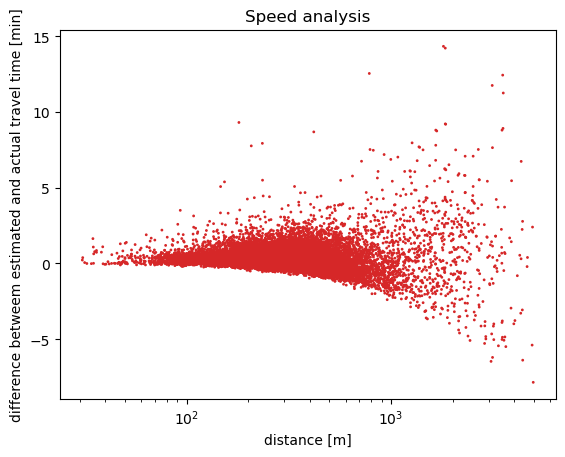

In [43]:
fig, ax = plt.subplots()

plt.xlabel("distance [m]")
plt.ylabel("difference betweem estimated and actual travel time [min]")

min_dist = 30
max_dist = 5000
mode_scatter, speed_scatter = ('bus', (1/speed_model_2.params[1])) 

plt.title('Speed analysis')

# x axis: distance between stops

plt.scatter(stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            &(stop_links['route_mode'] == mode_scatter)
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['distance'],

# y axis: residue from estimated travel time

            stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            &(stop_links['route_mode'] == mode_scatter)
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['time_avg'].apply(lambda x: x.total_seconds()/60)
            # discounting the time associated with the motion predicted in the model
            - (0.06/speed_scatter)*stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            &(stop_links['route_mode'] == mode_scatter)
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['distance'],
            
            s=1,

            c=stop_links[(stop_links['time_avg'] != dt.timedelta(minutes=1))
            &(stop_links['time_avg'] != dt.timedelta(minutes=2))
            &(stop_links['time_avg'] != dt.timedelta(minutes=3))
            &(stop_links['time_avg'] != dt.timedelta(minutes=4))
            &(stop_links['time_avg'] != dt.timedelta(minutes=5))
            &(stop_links['time_avg'] != dt.timedelta(minutes=6))
            &(stop_links['time_avg'] != dt.timedelta(minutes=7))
            &(stop_links['time_avg'] != dt.timedelta(minutes=8))
            &(stop_links['route_mode'] == mode_scatter)
            &(stop_links['speed'] > 1)
            &(stop_links['distance'] > min_dist)
            &(stop_links['distance'] < max_dist)]['route_mode'].map({'bus':'tab:red','tube':'tab:blue','tram':'tab:green'})
            # , cmap='Set1'
            # , norm=matplotlib.colors.Normalize(vmin=0, vmax=100)
           )

ax.set_xscale('log')
# ax.set_yscale('log')

plt.show()

Although there is a slight sway to negative values in proportion to distance, which implies less effects from slow acceleration and braking, the average value is roughly constant.

Another pattern is a visible increase of variance in proportion to distance, which is natural, as a tendency to a larger combination of outcomes is expected as there are more room for uncertain events to occur (using Euclidean distances may also be a factor).

This dataset is probably not suitable for further investigation into the nature of such penalties. Even discounting faulty data collection and the imperfect method for calculating the distances, there are few records of distances short to the point where penalties (equivalent to 15 to 45 seconds of travel time) would be relevant. Some tentative regressions have been performed with the assumption that most of this residue would be due to acceleration, but the results were absurd, with acceleration values reaching over several G. Therefore, it is plausible to infer that a great part of this discrepancy relates to exogenous factors.

Now, we can fill all the time data with estimated values:

$ t_{tube}[h] = \dfrac{dist[km]}{57.9} + 0.0084$

$ t_{tram}[h] = \dfrac{dist[km]}{51.1} + 0.0125$

$ t_{bus}[h] = \dfrac{dist[km]}{19.1} + 0.0439$

Even though this suppresses some fidelity with the real world, this is a way to be consistent and to avoid problems with unexpected artifacts and mistakes in data collection/consolidation.

In [44]:
# replacing values with estimated results of linear model
stop_links['time_est'] = stop_links['time_avg']

# replacing values with estimated results of linear model
stop_links.loc[stop_links['route_mode'] == 'tube', 'time_est'] = pd.to_timedelta(((3.6/57.9)*stop_links.loc[stop_links['route_mode'] == 'tube', 'distance'] + 30).round(0),unit='s')
stop_links.loc[stop_links['route_mode'] == 'tram', 'time_est'] = pd.to_timedelta(((3.6/51.1)*stop_links.loc[stop_links['route_mode'] == 'tram', 'distance'] + 45).round(0),unit='s')
stop_links.loc[stop_links['route_mode'] == 'bus', 'time_est'] = pd.to_timedelta(((3.6/19.1)*stop_links.loc[stop_links['route_mode'] == 'bus', 'distance'] + 16).round(0),unit='s')

In [45]:
stop_links.sample(3)

,stop_id_1,stop_id_2,route_mode,time_avg,time_std,stop_lat_1,stop_lon_1,stop_lat_2,stop_lon_2,stop_pos_1,stop_pos_2,distance,speed,time_est
22071,2450-490012557W,2450-490014713W,bus,0 days 00:00:54.691996766,0 days 00:00:13.821962343,189304.666521,531858.262667,189346.680597,531715.271289,POINT (531858.263 189304.667),POINT (531715.271 189346.681),149.035958,9.810018,0 days 00:00:44
7366,2450-490003062S,2450-490015585E,bus,0 days 00:02:10.526315789,0 days 00:00:22.921262118,185021.816233,505707.593638,184265.761954,505511.561349,POINT (505707.594 185021.816),POINT (505511.561 184265.762),781.054883,21.541998,0 days 00:02:43
21255,2450-490011988E,2450-490008836E,bus,0 days 00:00:58.249291784,0 days 00:00:16.731168376,162439.041223,535218.197568,162644.017018,535508.179967,POINT (535218.198 162439.041),POINT (535508.180 162644.017),355.112472,21.947132,0 days 00:01:23


In [46]:
# updating stop_shapes data frame (separated routes) with estimated travel time
stop_shapes = stop_shapes.merge(
    stop_links.iloc[:,np.r_[0,1,5:11,13]],
    on=['stop_id_1','stop_id_2'],
    how='left'
).drop(columns=['time_between']).drop_duplicates(['stop_id_1','stop_id_2','route_id']).reset_index()

In [47]:
stop_shapes.sample(3)

,index,stop_id_1,stop_id_2,route_mode,route_id,stop_lat_1,stop_lon_1,stop_lat_2,stop_lon_2,stop_pos_1,stop_pos_2,time_est
58487,3676290,2450-40004405077A,2450-40004405078A,bus,2450-8587,165196.092827,514340.431164,165568.154977,514797.436283,POINT (514340.431 165196.093),POINT (514797.436 165568.155),0 days 00:02:07
47903,283740,2450-490015145S,2450-490005152S,bus,2450-48580,177680.905549,526811.354844,177556.877843,526893.298076,POINT (526811.355 177680.906),POINT (526893.298 177556.878),0 days 00:00:44
45408,190160,2450-490003967S,2450-490012037S,bus,2450-3340,168482.050017,522443.387368,168294.042679,522384.354370,POINT (522443.387 168482.050),POINT (522384.354 168294.043),0 days 00:00:53


### Step #2: Setting up a full graph

_This is going to be made later. A provisional, simpler network will be used. Please skip to step #3._

TODO: Separating the graph in:

- **Pedestrian network:**
  - time between public transport stops calculated by walking distances within the street network
  - *(later other nodes can be added: spatial unit centroids and hypothetical stops of the dynamic public transport system)
  - a minimum spanning tree will be generated to reduce complexity
  - this will be the main network, where all information from outside the transport system gets connected with the spacetime medium
  - **[important!]** this is the subgraph where nodes from external sources will be allocated with approximate positions (e.g. in `pandanas`)

- **Waiting network:**
  - this relates with waiting times
  - it connects the pedestrian networks with the parts of the graph related to the public transport, practically from a z-dimension 0 to 1.
  - therefore, it is composed of one-way links only available in public transport stops
  - *later this will include hypothetical stops
  - *in the dynamic public transport system, the cost is half the headway of the hypothetical routes, which depend on the fleet size
 
- **Routes subgraphs:**
  - this is a collection of the shape of all the public transport routes
  - each route has a separated network that connects a sequence of stops
  - each separated network is accessed from the pedestrian network via the waiting network (with waiting costs) and has direct access to the pedestrian (with no costs)
  - *in the hypothetical dynamic system, every route is either circular or has a correspondent route that closes the loop, in order to simplify the fleet assigned the routes


## Generating a functioning network

Finally, we can use `pandana` to produce a travel cost matrix.

It is assumed that the most reliable variable generated here for expressing travel cost is travel time.

The full calculation of travel time derives mostly from the first method, which converts raw data into average travel times between stops, but other methods were used to help representing the network more consistently, replacing the raw data with a model based on it. The main changes are the Euclidean distances between stops generated by `geopandas` and the estimated values calculated by a linear model (provided by a regression made with the aid of `statsmodels`).

We can assemble the last inputs for the `pandana` network model: the tables `nodes_pt` and `edges_pt`.

#### Assembling a network made purely of public transport

In [48]:
# listing all nodes
nodes_pt = pd.DataFrame()
nodes_pt['stop_id'] = pd.concat([stop_shapes['stop_id_1'],stop_shapes['stop_id_2']])
nodes_pt['route_id'] = pd.concat([stop_shapes['route_id'],stop_shapes['route_id']])
nodes_pt['x'] = pd.concat([stop_shapes['stop_lon_1'],stop_shapes['stop_lon_2']])
nodes_pt['y'] = pd.concat([stop_shapes['stop_lat_1'],stop_shapes['stop_lat_2']])
# removing duplicates and setting integer indices
nodes_pt = nodes_pt.drop_duplicates(['stop_id','route_id']).sort_values(['stop_id','route_id']).reset_index(drop=True)

In [49]:
nodes_pt.sample(3)

,stop_id,route_id,x,y
18319,2450-490004477N1,2450-14075,550131.142610,176797.931534
32786,2450-490008512TJ,2450-10056,516176.459069,175874.954877
48280,2450-490012723S,2450-14074,521554.394813,167713.096859


In [50]:
edges_pt = stop_shapes[['stop_id_1','stop_id_2','route_id']].reset_index(drop=True).copy()

# transforming node ID codes to integer values
edges_pt['from'] = edges_pt.merge(
    nodes_pt.join(pd.DataFrame(nodes_pt.index.values).rename({0:'index'}, axis=1)),
    left_on = ['stop_id_1','route_id'],
    right_on = ['stop_id','route_id'],
    how = 'left'
)['index']

edges_pt['to'] = edges_pt.merge(
    nodes_pt.join(pd.DataFrame(nodes_pt.index.values).rename({0:'index'}, axis=1)),
    left_on = ['stop_id_2','route_id'],
    right_on = ['stop_id','route_id'],
    how = 'left'
)['index']

# adding travel time information
edges_pt['time'] = stop_shapes['time_est'].apply(lambda x: x.total_seconds())

In [51]:
edges_pt.sample(3)

,stop_id_1,stop_id_2,route_id,from,to,time
10637,2450-490013869S,2450-490013865S,2450-3303,52876,52858,61.0
15164,2450-490003311N,2450-490012353W,2450-90767,13933,47017,73.0
24949,2450-490015484W,2450-490013392N,2450-11519,59022,50768,70.0


In [52]:
# nw_pt = pdna.Network(nodes_pt['x'],
#                      nodes_pt['y'],
#                      edges_pt.set_index(['from','to'], drop=False)['from'],
#                      edges_pt.set_index(['from','to'], drop=False)['to'],
#                      edges_pt.set_index(['from','to'], drop=False)[['time']])

We could use the `get_node_ids` and `shortest_path_lengths` methods from this point to calculate a travel time matrix, but there are two main obstacles:

(1) The public transport network, as described in the GTFS, is fragmented by routes, so any interchange between lines cannot be computed by the model without some representation of a supplementary network. This can be expressed by a new network that incorporates the street network, as seen in the following procedures.

(2) There are too many nodes. This is not much of an issue for assembling the network, but this could be very restrictive if places in the network are to be origins and destinations – potentially all nodes in a given graph or regular grid. An array of few tens of thousands can generate a combination of the order of hundred millions or billions of rows expressing pairs of origins and destinations.

#### Generating walking travel times within the street network

We're going to divide the study area in regular grids. The H3 hexagonal hierarchical grid from Uber (see [h3-py documentation](https://uber.github.io/h3-py/intro.html) and [h3-py on github](https://github.com/uber/h3-py?tab=readme-ov-file)) is a good reference as it is widely used and can provide multiple standardised scales.

We could follow the [recommended snippet for initialisation](https://uber.github.io/h3-py/polygon_tutorial.html) for importing libraries and defining useful custom functions with `geopandas` or other procedures solely from the `h3-py` module, but the `h3fy` method from the `tobler` module is a convenient tool for generating the grid (see [tutorial](https://pysal.org/tobler/notebooks/census_to_hexgrid.html)).

##### Generating a hexagonal grid
First, the study area must be determined. This was made off-screen with GIS softwares and external shapefiles for expressing boundaries and land use – the built-up areas (BUA, 2024) of England and Wales; the Greater London boundary; and the UK Travel to Work Areas (TTWA, 2011).

Apart from all the built-up space inside the boundary of the Greater London area, all built-up polygons within 800 m from a public transport stop inside the TTWAs corresponding London (London and Slough/Heathrow) were included. Additionaly, outside the TTWA boundaries, an 800-meter buffer from stops related to routes adjacent to the metropolitan network. Some remaining public transport stops very far from London in Southern England (Gloucestershire, Kent etc.) were not considered.

This produced a shapefile with the built-up area which is the base of the hexagonal grid. The line below imports the shapefile and transforms it in a geodataframe.

In [53]:
bua_london = gpd.read_file("data/GIS/BUA_london_selection.shp", low_memory=False)

In [54]:
bua_london.sample(2)

,OBJECTID_1,gsscode,BUA24CD,BUA24NM,BUA24NMW,geometry_a,areahectar,GlobalID,study_area,geometry
116,5061,EUE006487,E63012152,Stone (Dartford),None,1653125.0,165.31,2e244f71-3cb0-4fa4-a11e-ec496f3d51da,2,"MULTIPOLYGON (((557325.000 173525.000, 557325...."
7,4512,EUE005753,E63011603,North Weald Bassett,None,2197500.0,219.75,6c6ce31c-bd1b-465c-839d-51e7dffcec02,3,"MULTIPOLYGON (((548700.000 203775.000, 548700...."


Plotting this geodataframe (with a basemap using `contextily`):

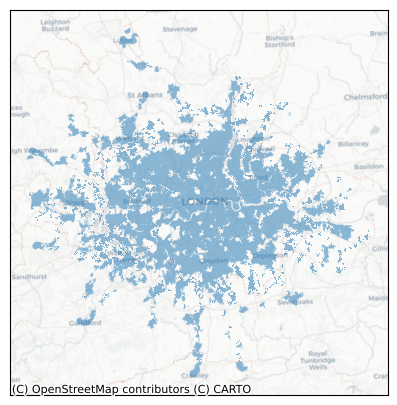

In [55]:
fig, ax = plt.subplots(figsize=(5,5))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
    
bua_london.plot(
    ax=ax,
    alpha=0.5, edgecolor=None,
    column=None, categorical=True,
    legend=True, legend_kwds={'loc': 'upper left'}, 
)
cx.add_basemap(ax, crs=bua_london.crs, source=cx.providers.CartoDB.Positron)

Converting geodataframe into hexagonal grid of approximately 125 m (± a standard deviation of 4.4 m) ([h3 grid, resolution 10](https://h3geo.org/docs/core-library/restable/)) with the `h3fy` method:

In [56]:
hex_london = h3fy(bua_london, resolution=10)
hex_london.sample(2)

# long procedure (~3min)

C:\Users\Pedro\anaconda3\envs\env_311_8\Lib\site-packages\pyproj\crs\crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


,geometry
hex_id,
8a195dac9907fff,"POLYGON ((513967.139 180068.238, 513900.984 18..."
8a195da25937fff,"POLYGON ((521465.466 207817.258, 521399.451 20..."


Plotting the new geodataframe with the hexgrid (note that the hexagons are tiny and the change is almost imperceptible):

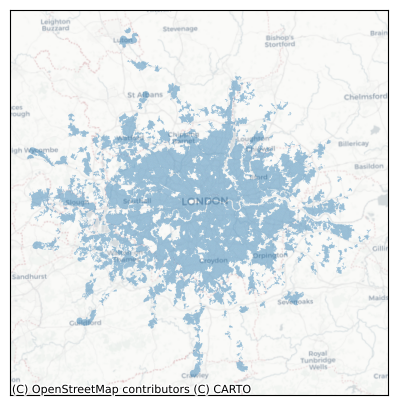

In [57]:
fig, ax = plt.subplots(figsize=(5,5))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
    
hex_london.plot(
    ax=ax,
    alpha=0.5, edgecolor=None,
    column=None, categorical=True,
    legend=True, legend_kwds={'loc': 'upper left'}, 
)
cx.add_basemap(ax, crs=hex_london.crs, source=cx.providers.CartoDB.Positron)

Checking the number of hexagonal cells:

In [58]:
hex_london.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 131156 entries, 8a195d229b2ffff to 8a194e620267fff
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  131156 non-null  geometry
dtypes: geometry(1)
memory usage: 6.0+ MB


##### Calculating a vicinity table

A model simulating the street network will be based on this hexagonal grid. It is important to restrict the connections between the hexagons only to their neighbours in order to be feasible to estimate distances.

In [59]:
hex_london['centroids'] = hex_london['geometry'].centroid
hex_london.sample(3)

,geometry,centroids
hex_id,,
8a194ad4d15ffff,"POLYGON ((550821.379 155889.613, 550755.476 15...",POINT (550811.134 155818.149)
8a195da1cd9ffff,"POLYGON ((511284.796 200702.292, 511218.676 20...",POINT (511274.416 200630.951)
8a194acb6237fff,"POLYGON ((511313.668 165722.223, 511247.450 16...",POINT (511303.264 165650.657)


There are many ways to find the neighbouring centroids (e.g. using buffers), but a fast way is checking intersections between the hexagons.

In [60]:
# spatial join to find all intersecting polygons and filtering for self-intersections
temp_join = gpd.sjoin(hex_london.sort_values(by='centroids'), hex_london.sort_values(by='centroids'), how='inner', predicate='intersects')
temp_join = temp_join.reset_index(drop=False)
temp_join = temp_join[temp_join['hex_id'] != temp_join['index_right']].reset_index(drop=True)

# setting a new dataframe listing all connections between neighbouring hexagons
vicinity = pd.DataFrame()
vicinity['hex_id_1'] = temp_join['hex_id']
vicinity['hex_id_2'] = temp_join['index_right']
vicinity['centroids_1'] = temp_join['centroids_left']
vicinity['centroids_2'] = temp_join['centroids_right']

temp_join = None

In [61]:
display(vicinity.info(show_counts=True))
vicinity.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710558 entries, 0 to 710557
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   hex_id_1     710558 non-null  object  
 1   hex_id_2     710558 non-null  object  
 2   centroids_1  710558 non-null  geometry
 3   centroids_2  710558 non-null  geometry
dtypes: geometry(2), object(2)
memory usage: 21.7+ MB


None

,hex_id_1,hex_id_2,centroids_1,centroids_2
255602,8a195da11a27fff,8a195da11b0ffff,POINT (511322.480 201395.099),POINT (511398.977 201487.009)
541269,8a194e6ea607fff,8a194e6ea61ffff,POINT (554529.887 174305.535),POINT (554453.846 174213.535)
547214,8a194e6ecb0ffff,8a194e6ecb1ffff,POINT (559041.453 177288.729),POINT (558920.102 177318.723)


##### Using a Pandana network to calculate walking distances

Using `pandana`'s integration with [OpenStreetMap](https://osm.org)

Setting a new `pandana` network only for walking:

In [62]:
# setting a bbox
bounds = [bua_london.to_crs('EPSG:4326').bounds.iloc[:,0].min(),
          bua_london.to_crs('EPSG:4326').bounds.iloc[:,1].min(),
          bua_london.to_crs('EPSG:4326').bounds.iloc[:,2].max(),
          bua_london.to_crs('EPSG:4326').bounds.iloc[:,3].max()]

# importing the street network from OSM within the bbox
nw_walk = osm.pdna_network_from_bbox(bounds[1], bounds[0], bounds[3], bounds[2], network_type='walk')

# long procedure (~15 min):
winsound.PlaySound('ding.wav', winsound.SND_FILENAME)

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](51.10631733,-0.77585961,51.52248287,-0.14559003);>;);out;'}"
Downloaded 197,962.7KB from www.overpass-api.de in 33.50 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](51.50883156,-0.77585961,51.91001199,-0.12020608);>;);out;'}"
Downloaded 150,928.3KB from www.overpass-api.de in 15.39 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestria

Calculating distances within street network:

In [63]:
# using the same CRS as the OSM network
nodes_1 = gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_1'], crs='EPSG:27700').to_crs('EPSG:4326')['geometry']
nodes_2 = gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_2'], crs='EPSG:27700').to_crs('EPSG:4326')['geometry']

# turning off warnings, as many nodes cannot be allocated in the OSM network
warnings.filterwarnings('ignore')

# estimating nearest positions in the network and calculating distances
vicinity['distances'] = nw_walk.shortest_path_lengths(
    nw_walk.get_node_ids(nodes_1.x, nodes_1.y).values,
    nw_walk.get_node_ids(nodes_2.x, nodes_2.y).values)

# turning on warnings again
warnings.filterwarnings('always')

Saving a dataframe to report unusual values:

In [64]:
# adding coordinates in WGS84 to be easily checked 
vicinity['ctr1_wgs84'] = gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_1'], crs='EPSG:27700').to_crs('EPSG:4326')['geometry']
vicinity['ctr2_wgs84'] = gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_2'], crs='EPSG:27700').to_crs('EPSG:4326')['geometry']

In [65]:
# calculating the distance of the shortest straight line possible within the bbox
gpd.GeoSeries(vicinity['centroids_1']).distance(gpd.GeoSeries(vicinity['centroids_2'])).min()

119.02683484610677

In [66]:
# separating unusual values
weird_distances = vicinity[
(vicinity['distances'] == 4294967.295) # distance could not be estimated
|(vicinity['distances'] < 119) # values below the shortest distance, due to allocation in nodes close to each other
]

weird_distances.sample(5)

,hex_id_1,hex_id_2,centroids_1,centroids_2,distances,ctr1_wgs84,ctr2_wgs84
389493,8a194e691b97fff,8a194e6918cffff,POINT (536991.684 189719.701),POINT (536946.322 189841.708),108.414,POINT (-0.02387 51.58968),POINT (-0.02448 51.59079)
690911,8a194ad719affff,8a194ad7191ffff,POINT (545812.340 166590.792),POINT (545933.915 166560.822),91.350,POINT (0.09382 51.37965),POINT (0.09556 51.37935)
672240,8a194ac2a577fff,8a194ac2a557fff,POINT (533592.504 158722.065),POINT (533516.142 158629.769),98.056,POINT (-0.08460 51.31194),POINT (-0.08573 51.31113)
42548,8a194ac1674ffff,8a194ac16667fff,POINT (522813.365 162707.289),POINT (522736.880 162614.981),82.953,POINT (-0.23781 51.35018),POINT (-0.23894 51.34937)
222216,8a195d84b297fff,8a195d84b667fff,POINT (511078.363 221393.803),POINT (510956.599 221424.084),0.000,POINT (-0.38766 51.88006),POINT (-0.38942 51.88036)


_Replacing unusual values:_

We can calculate reasonable stopgaps to the methodological flaws by assigning the general trends of the valid portion of the results

In [67]:
# assessing the distribution of values, excluding absurd values
vicinity[
(vicinity['distances'] < 4294967.295)
&(vicinity['distances'] > 119)
]['distances'].describe()

count    549618.000000
mean        319.423987
std         290.812257
min         119.002000
25%         165.673000
50%         227.829000
75%         365.790000
max       10048.456000
Name: distances, dtype: float64

Trying to emulate valid results:

In [68]:
# replacing high values: median + 2.5 std 

vicinity.loc[vicinity['distances'] == 4294967.295, 'distances'] = vicinity[
(vicinity['distances'] < 4294967.295)
&(vicinity['distances'] > 119)
]['distances'].median() + 2.5* vicinity[
(vicinity['distances'] < 4294967.295)
&(vicinity['distances'] > 119)
]['distances'].std()

# replacing low values: mean

vicinity.loc[vicinity['distances'] < 119, 'distances'] = vicinity[
(vicinity['distances'] < 4294967.295)
&(vicinity['distances'] > 119)
]['distances'].mean()

# checking again dataframe discriminators

vicinity['distances'].describe()

count    710558.000000
mean        322.774065
std         258.966794
min         119.000000
25%         180.568250
50%         292.146000
75%         322.775212
max       10048.456000
Name: distances, dtype: float64

##### Creating a simplified walking network

Generating a new network with only the distance between the centroids of the hexagonal cells and their neighbouring cells.

In [69]:
# listing all nodes
nodes_hexwalk = pd.DataFrame()
nodes_hexwalk['hex_id'] = pd.concat([vicinity['hex_id_1'],vicinity['hex_id_2']])
nodes_hexwalk['x'] = pd.concat([gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_1'], crs='EPSG:27700')['geometry'].x,
                                gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_2'], crs='EPSG:27700')['geometry'].x])
nodes_hexwalk['y'] = pd.concat([gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_1'], crs='EPSG:27700')['geometry'].y,
                                gpd.GeoDataFrame(vicinity, geometry=vicinity['centroids_2'], crs='EPSG:27700')['geometry'].y])
# removing duplicates and setting integer indices
nodes_hexwalk = nodes_hexwalk.drop_duplicates('hex_id').sort_values('hex_id').reset_index(drop=True)

In [70]:
# listing all edges
edges_hexwalk = vicinity[['hex_id_1','hex_id_2']].sort_values(['hex_id_1','hex_id_2']).reset_index(drop=True).copy()

# transforming node IDs to integer values
edges_hexwalk['from'] = edges_hexwalk.merge(
    nodes_hexwalk.join(pd.DataFrame(nodes_hexwalk.index.values, columns=['index'])),
    left_on = 'hex_id_1',
    right_on = 'hex_id',
    how = 'left'
)['index']

edges_hexwalk['to'] = edges_hexwalk.merge(
    nodes_hexwalk.join(pd.DataFrame(nodes_hexwalk.index.values, columns=['index'])),
    left_on = 'hex_id_2',
    right_on = 'hex_id',
    how = 'left'
)['index']

edges_hexwalk['time'] = vicinity.sort_values(['hex_id_1','hex_id_2']).reset_index(drop=True)['distances']*(3600/5000) # assuming a walking speed of 5 km/h

Calculating size of the simplified network to compare with the full street network graph (1,106,480 nodes and 1,472,930 edges):

In [71]:
len(nodes_hexwalk), len(edges_hexwalk)

(130902, 710558)

The resulting graph is very light in relation to the original (around 10% of nodes and 50% of edges). This is convenient not only for storage and processing but also because the time loading the network with the API can be saved. Also, the OSM platform is vulnerable to frequent change and incidental vandalism. Now, we can save the generating dataframes:

In [72]:
nodes_hexwalk.to_csv('data/nodes_hexwalk_london.txt', index=False)
edges_hexwalk.to_csv('data/edges_hexwalk_london.txt', index=False)
# the edge data frame must prepared with df = df.set_index(['from','to'], drop=False)
# (where df = pd.read_csv('data/edges_hexwalk_london.txt'))

In [73]:
### EXAMPLE

# nodes_hexwalk = pd.read_csv('data/nodes_hexwalk_london.txt')
# edges_hexwalk = pd.read_csv('data/edges_hexwalk_london.txt')
# nw_hexwalk = pdna.Network(
#     nodes_hexwalk['x'],
#     nodes_hexwalk['y'],
#     edges_hexwalk.set_index(['from','to'], drop=False)['from'],
#     edges_hexwalk.set_index(['from','to'], drop=False)['to'],
#     edges_hexwalk.set_index(['from','to'], drop=False)[['time']])

In [74]:
# setting up the Pandana network
nw_hexwalk = pdna.Network(
    nodes_hexwalk['x'],
    nodes_hexwalk['y'],
    edges_hexwalk.set_index(['from','to'], drop=False)['from'],
    edges_hexwalk.set_index(['from','to'], drop=False)['to'],
    edges_hexwalk.set_index(['from','to'], drop=False)[['time']],
    twoway=False)

#### Merging the public transport network with the walking network

Public transport stops close to each other may be allocated to the same nodes when assigned to the network. Let's see how many of them are unified in same hexagon cells:

In [75]:
nodes_pt.sample(3)

,stop_id,route_id,x,y
26802,2450-490006947E,2450-5812,528041.263627,189637.636287
55789,2450-490014652F,2450-32843,538373.120154,165721.928957
26445,2450-490006827W,2450-84339,534164.143208,181548.805600


Getting coordinates related to the walking network hexgrid for `nodes_pt`:

In [76]:
stop_hex = nw_hexwalk.get_node_ids(nodes_pt.x, nodes_pt.y).rename('stop_hex')
stop_hex.count(), stop_hex.nunique()

(62267, 16797)

Generating new dataframes for the `pandana` network, first adding nodes relating to the public transport routes:

In [77]:
# merging node dataframes for walking and public transport
nodes_walkpt = pd.concat([nodes_hexwalk,
                          nodes_pt.join(stop_hex).sort_values(by=['stop_hex','route_id']).reset_index(drop=True)
                         ]).reset_index(drop=True)

In [78]:
nodes_walkpt.sample(4)

,hex_id,x,y,stop_id,route_id,stop_hex
58089,8a194e6806d7fff,540183.069144,189151.364761,NaN,NaN,NaN
166275,NaN,535498.227325,193811.800920,2450-490009993W,2450-7414,62941.0
128806,8a195db5e497fff,524025.760409,201128.252557,NaN,NaN,NaN
50826,8a194adb6c07fff,515991.679494,182269.913590,NaN,NaN,NaN


Generating new edges related to waiting time and alighting

In [79]:
edges_interface = pd.DataFrame()
edges_interface['from'] = pd.concat([nodes_walkpt[~nodes_walkpt['stop_hex'].isna()].loc[:,'stop_hex'].astype(int),
                                     pd.Series(nodes_walkpt[~nodes_walkpt['stop_hex'].isna()].index.values)]).reset_index(drop=True)
edges_interface['to'] = pd.concat([pd.Series(nodes_walkpt[~nodes_walkpt['stop_hex'].isna()].index.values),
                                   nodes_walkpt[~nodes_walkpt['stop_hex'].isna()].loc[:,'stop_hex'].astype(int)]).reset_index(drop=True)

# getting waiting time from custom-made stop_headways
## ATTENTION: the travel time to access the stops was disregarded

edges_interface['time'] = edges_interface.merge(

nodes_walkpt.merge(stop_headways[['stop_id','route_id','hw_min_day']],
                   on=['stop_id','route_id'],
                   how='left'),
    
    left_on='to',
    right_index=True,
    how='left'

)['hw_min_day'].apply(lambda x: x.total_seconds()).fillna(0) # NA values mean alighting (travel cost/time = 0)

# adding hex and stop information
edges_interface[['hex_id_1','stop_id_1']] = edges_interface.merge(nodes_walkpt,left_on='from',right_index=True,how='left')[['hex_id','stop_id']]
edges_interface[['hex_id_2','stop_id_2']] = edges_interface.merge(nodes_walkpt[['hex_id','stop_id']],left_on='to',right_index=True,how='left')[['hex_id','stop_id']]
edges_interface['route_id'] = edges_interface.merge(nodes_walkpt,left_on='to',right_index=True,how='left')['route_id']

In [80]:
stop_headways.sample(3)

,route_id,trip_headsign,stop_id,hw_min_day
8791,2450-11438,Wandsworth,2450-490013593WL,0 days 00:11:40
6305,2450-11142,Wallington,2450-490001306A,0 days 00:03:33
61006,2450-9217,Worcester Park,2450-490014135S2,0 days 00:03:45


In [81]:
edges_interface.sample(5)

,from,to,time,hex_id_1,stop_id_1,hex_id_2,stop_id_2,route_id
80086,148721,32268,0.0,NaN,2450-490009281E,8a194ad33407fff,NaN,NaN
28362,48132,159264,222.0,8a194adac597fff,NaN,NaN,2450-490014184W,2450-34651
18492,32735,149394,101.0,8a194ad3490ffff,NaN,NaN,2450-490014373LA,2450-3360
110513,179148,101773,0.0,NaN,2450-490013767T,8a195da49a07fff,NaN,NaN
113798,182433,105416,0.0,NaN,2450-490008335N,8a195da56287fff,NaN,NaN


Generating new edges related to in-vehicle travel

In [82]:
# creating copies of the in-vehicle travel edge lists

edges_pt_copy = edges_pt.reset_index(drop=True).copy()

# updating node indices

edges_pt_copy['from'] = edges_pt_copy.merge(
    nodes_walkpt.reset_index(drop=False),left_on=['stop_id_1','route_id'],right_on=['stop_id','route_id'],how='left'
)['index'].astype(int)
edges_pt_copy['to'] = edges_pt_copy.merge(
    nodes_walkpt.reset_index(drop=False),left_on=['stop_id_2','route_id'],right_on=['stop_id','route_id'],how='left'
)['index'].astype(int)

In [83]:
edges_pt_copy.sample(3)

,stop_id_1,stop_id_2,route_id,from,to,time
13994,2450-9400ZZLUVIC2,2450-9400ZZLUGPK1,2450-3289,142292,178665,95.0
26117,2450-490017361E,2450-490017362E,2450-90773,149147,148993,71.0
4679,2450-490004687Q,2450-490005464V,2450-7397,141866,141850,75.0


In [84]:
# merging edge dataframes (walking + waiting + public transport)
edges_walkpt = pd.concat([edges_hexwalk.reset_index(drop=True).copy().sort_values(by=['from','to']),
                          edges_interface.sort_values(by=['from','to']).reset_index(drop=True),
                          edges_pt_copy.sort_values(by=['from','to']).reset_index(drop=True)
                         ]).reset_index(drop=True)

In [85]:
edges_walkpt.sample(5)

,hex_id_1,hex_id_2,from,to,time,stop_id_1,stop_id_2,route_id
82885,8a194acb259ffff,8a194acb24a7fff,15719,15698,1271.83320,NaN,NaN,NaN
690963,8a195db4b58ffff,8a195db4b417fff,127153,127112,203.91192,NaN,NaN,NaN
763322,8a195da5d62ffff,NaN,107310,183666,132.00000,NaN,2450-490010521N,2450-8301
741253,8a194e6102d7fff,NaN,52301,161597,316.00000,NaN,2450-490008235E,2450-5857
580318,8a195da5c8cffff,8a195da5cbb7fff,107059,107126,161.07552,NaN,NaN,NaN


In [86]:
len(nodes_walkpt), len(edges_walkpt)

(193169, 896820)

This graph has many redundancies and `pandana` will not work if the superimposed nodes, edges and coordinates are not dropped or modified.

In [87]:
# first check for duplicated lat-lon coordinates
nodes_walkpt[nodes_walkpt[['x','y']].duplicated(keep=False)].sort_values(by=['x','y'])

,hex_id,x,y,stop_id,route_id,stop_hex
173566,NaN,383527.772986,218528.194286,2450-160000640,2450-31959,79706.0
173571,NaN,383527.772986,218528.194286,2450-160000640,2450-89,79706.0
173514,NaN,385445.731539,219417.262136,2450-1600GL5750,2450-31959,79630.0
173559,NaN,385445.731539,219417.262136,2450-1600GL5750,2450-89,79630.0
173513,NaN,385593.714551,219524.163080,2450-1600GL5749,2450-31959,79630.0
...,...,...,...,...,...,...
130933,NaN,567105.976970,145885.142900,2450-2400104986,2450-11173,403.0
130941,NaN,567105.976970,145885.142900,2450-2400104986,2450-2249,403.0
130928,NaN,567110.998376,145907.122519,2450-240082590,2450-10757,403.0
130934,NaN,567110.998376,145907.122519,2450-240082590,2450-11173,403.0


In [88]:
# locating multiple instances of the same coordinate in each route (ex: stops with more than one stop_id)

duplicates_new_ref = pd.DataFrame()

duplicates_new_ref['index'] = nodes_walkpt.reset_index(drop=False)[~nodes_walkpt['stop_id'].isna()]['index']
duplicates_new_ref['x'] = nodes_walkpt[~nodes_walkpt['stop_id'].isna()]['x']
duplicates_new_ref['y'] = nodes_walkpt[~nodes_walkpt['stop_id'].isna()]['y']
duplicates_new_ref['route_id'] = nodes_walkpt[~nodes_walkpt['stop_id'].isna()]['route_id']

duplicates_new_ref = duplicates_new_ref.merge(
    duplicates_new_ref.groupby(['x', 'y','route_id'])['index'].first().reset_index(),
    on=['x', 'y', 'route_id'],
    how='left',
    suffixes=('','_unique'))

In [89]:
# checking the duplicated codes

duplicates_new_ref[duplicates_new_ref['index_unique'].duplicated(keep=False)].sort_values(by=['x', 'y','route_id']).head(10)

,index,x,y,route_id,index_unique
1151,132053,524443.295958,162448.102816,2450-91948,132053
1152,132054,524443.295958,162448.102816,2450-91948,132053
4228,135130,526576.285721,168785.093585,2450-11806,135130
4229,135131,526576.285721,168785.093585,2450-11806,135130
8937,139839,529263.259822,176182.884305,2450-3332,139839
8938,139840,529263.259822,176182.884305,2450-3332,139839
8939,139841,529263.259822,176182.884305,2450-71295,139841
8940,139842,529263.259822,176182.884305,2450-71295,139841
8941,139843,529263.259822,176182.884305,2450-7190,139843
8942,139844,529263.259822,176182.884305,2450-7190,139843


In [90]:
# dropping non-unique stops

nodes_walkpt = nodes_walkpt.copy()

nodes_walkpt.loc[~nodes_walkpt['stop_id'].isna()] = nodes_walkpt.reset_index(drop=False).merge(

    duplicates_new_ref[['index','index_unique']],
    on='index',
    how='left'

).drop(columns=['index']).loc[~nodes_walkpt['stop_id'].isna()].drop_duplicates('index_unique')

nodes_walkpt = nodes_walkpt.dropna(subset=['x'])

In [91]:
len(nodes_walkpt), len(edges_walkpt)

(193150, 896820)

In [92]:
# replacing nodes from edges with unique ids

edges_walkpt = edges_walkpt.copy()

# in-vehicle and alighting edges

edges_walkpt.loc[~edges_walkpt['stop_id_1'].isna(),'from'] = edges_walkpt.merge(

    duplicates_new_ref[['index','index_unique']],
    left_on='from',
    right_on='index',
    how='left'

).loc[~edges_walkpt['stop_id_1'].isna(),'index_unique']

# in-vehicle and waiting edges

edges_walkpt.loc[~edges_walkpt['stop_id_2'].isna(),'to'] = edges_walkpt.merge(

    duplicates_new_ref[['index','index_unique']],
    left_on='to',
    right_on='index',
    how='left'

).loc[~edges_walkpt['stop_id_2'].isna(),'index_unique']

# dropping duplicates

edges_walkpt = edges_walkpt.drop_duplicates(['from','to']).loc[edges_walkpt['from'] != edges_walkpt['to']]

In [93]:
len(nodes_walkpt), len(edges_walkpt)

(193150, 896782)

In [94]:
# shifting coordinates by less than 10 cm to undo the superimposition of public transport stops

increment = []
current_route = None
i=0

for index in nodes_walkpt.sort_values(by=['route_id']).itertuples():
    if index.route_id != current_route:
        i += 0.0001
    increment.append(i)
    current_route = index.route_id

nodes_walkpt['y'] += pd.Series(increment, index=nodes_walkpt.index)

# discarding temp values
increment = None

In [95]:
# checking for duplicates
print('duplicated coordinates')
display(nodes_walkpt[nodes_walkpt[['x','y']].duplicated(keep=False)].sort_values(by=['x','y']))

# checking for mismatches between edges and nodes
print('mismatches')
display(nodes_walkpt[~nodes_walkpt.index.isin(edges_walkpt['from'])])
display(nodes_walkpt[~nodes_walkpt.index.isin(edges_walkpt['to'])])
display(edges_walkpt[~edges_walkpt['from'].isin(nodes_walkpt.index)])
display(edges_walkpt[~edges_walkpt['to'].isin(nodes_walkpt.index)])

print('NaN')
# checking for NaN values
display(nodes_walkpt[nodes_walkpt['x'].isna()])
display(nodes_walkpt[nodes_walkpt['y'].isna()])
display(edges_walkpt[edges_walkpt['from'].isna()])
display(edges_walkpt[edges_walkpt['to'].isna()])
display(edges_walkpt[edges_walkpt['time'].isna()])

duplicated coordinates


,hex_id,x,y,stop_id,route_id,stop_hex


mismatches


,hex_id,x,y,stop_id,route_id,stop_hex


,hex_id,x,y,stop_id,route_id,stop_hex


,hex_id_1,hex_id_2,from,to,time,stop_id_1,stop_id_2,route_id


,hex_id_1,hex_id_2,from,to,time,stop_id_1,stop_id_2,route_id


NaN


,hex_id,x,y,stop_id,route_id,stop_hex


,hex_id,x,y,stop_id,route_id,stop_hex


,hex_id_1,hex_id_2,from,to,time,stop_id_1,stop_id_2,route_id


,hex_id_1,hex_id_2,from,to,time,stop_id_1,stop_id_2,route_id


,hex_id_1,hex_id_2,from,to,time,stop_id_1,stop_id_2,route_id


In [96]:
# final graph
len(nodes_walkpt), len(edges_walkpt)

(193150, 896782)

Now, we can set up the network:

In [97]:
# clearing memory from heavy data frames that are not being used

# EARLY DROP AT CELL 35

stop_times = None # 7.5 GiB using custom sys function (see initialisation)
trips = None # 106.1 MiB using custom sys function (see initialisation)

# around 700 MiB still being used

In [98]:
nodes_walkpt.to_csv('data/nodes_walkpt.txt', index=False)
edges_walkpt.to_csv('data/edges_walkpt.txt', index=False)
# the edge data frame must prepared with df = df.set_index(['from','to'], drop=False)
# (where df = pd.read_csv('data/edges_walkpt.txt'))

In [99]:
# setting up the Pandana network
nw_walkpt = pdna.Network(
                        nodes_walkpt['x'],
                        nodes_walkpt['y'],
                        edges_walkpt.set_index(['from','to'], drop=False)['from'],
                        edges_walkpt.set_index(['from','to'], drop=False)['to'],
                        edges_walkpt.set_index(['from','to'], drop=False)[['time']],
                        twoway=False)

## Calculating travel time matrices

#### Travel matrix for public transport stops (16797 x 16797)

Preparing origins and destinations:

In [100]:
# nodes_D, nodes_O = np.meshgrid(nodes_allocated.sort_values().unique(), nodes_allocated.sort_values().unique())

# nodes_O = nodes_O.ravel()
# nodes_D = nodes_D.ravel()

Calculating travel time:

In [101]:
# import time
# start = time.time()

# distances = nw_walkpt.shortest_path_lengths(nodes_O, nodes_D)

# end = time.time()
# print(end - start)

#### Travel matrix for h3 resolution 8 (2668 x 2668)

Generating new hexagons and their centroids:

In [102]:
hex_london_res8 = h3fy(bua_london, resolution=8)
hex_london_res8['centroids'] = hex_london_res8['geometry'].centroid
hex_london_res8.sample(3)

C:\Users\Pedro\anaconda3\envs\env_311_8\Lib\site-packages\pyproj\crs\crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


,geometry,centroids
hex_id,,
88194ac205fffff,"POLYGON ((533404.354 165283.468, 532942.141 16...",POINT (533332.147 164783.122)
88195daec9fffff,"POLYGON ((516935.258 188768.738, 516472.503 18...",POINT (516862.700 188268.960)
88194a8b2dfffff,"POLYGON ((551808.520 155313.785, 551347.223 15...",POINT (551736.811 154813.523)


In [103]:
len(hex_london_res8.centroids)

2668

Preparing origins and destinations:

In [104]:
# allocating hexagon centroids into the WALKING network
#### ATTENTION: walking network
nodes_res8 = nw_hexwalk.get_node_ids(
    gpd.GeoDataFrame(hex_london_res8, geometry=hex_london_res8['centroids'], crs='EPSG:27700')['geometry'].x,
    gpd.GeoDataFrame(hex_london_res8, geometry=hex_london_res8['centroids'], crs='EPSG:27700')['geometry'].y)

# appending as a new column to cross the references
hex_london_res8 = hex_london_res8.join(nodes_res8)
hex_london_res8['h3res8'] = hex_london_res8.index.values

In [105]:
# creating a matrix combining pairs of nodes
nodes_D, nodes_O = np.meshgrid(nodes_res8.sort_values(), nodes_res8.sort_values())
nodes_O = nodes_O.ravel()
nodes_D = nodes_D.ravel()

Running the shortest path algorithm:

In [106]:
# calculating distances in the FULL network
#### ATTENTION: full network
TT = nw_walkpt.shortest_path_lengths(nodes_O, nodes_D)

# this snippet took around 90 seconds to finish

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



##### Results

Generating a proper table:

In [107]:
# generating a data frame
travel_matrix = pd.DataFrame()
travel_matrix['node_id_1'], travel_matrix['node_id_2'], travel_matrix['tt'] = pd.Series(nodes_O), pd.Series(nodes_D), pd.Series(TT)

# adding geographical reference
travel_matrix = travel_matrix.merge(
    
    hex_london_res8[['geometry','centroids','h3res8','node_id']],
    left_on='node_id_1',
    right_on='node_id',
    how='left'
    
    ).rename(
    
    columns={'geometry':'geometry_1','centroids':'centroids_1','h3res8':'h3res8_1'}

    ).drop(

    columns=['node_id']
    
        ).merge(
        
        hex_london_res8[['geometry','centroids','h3res8','node_id']],
        left_on='node_id_2',
        right_on='node_id',
        how='left'

        ).rename(
    
        columns={'geometry':'geometry_2','centroids':'centroids_2','h3res8':'h3res8_2'}
    
        ).drop(
    
        columns=['node_id']
    
        )

In [108]:
# exporting data
travel_matrix.to_csv('data/tt_hex_london_res8.txt', index=False)

Making shallow evaluations of the results:

In [109]:
TT = pd.Series(TT)

In [110]:
len(hex_london_res8)

2668

In [111]:
TT.max()

4294967.295

In [112]:
(
# values too large: could not compute
len(TT[
TT == TT.max()
]), 

# reasonable values 
len(TT[
(TT != TT.max()) & (TT > 600) # 10 min (600 s) is the approximate distance between cells by foot
]),

# too fast/values too low
len(TT[
(TT != 0) & (TT < 600)
]),
 
# proportion of valid values
len(TT[(
TT != TT.max()) & (TT != 0) 
]
)/len(TT[TT != 0]))

(518204, 6597064, 288, 0.9271730838742609)

In [113]:
TT[(TT != TT.max()) & (TT != 0)].round(0).describe(
    ).apply(lambda x: format(x, 'g'))

count    6.59735e+06
mean         7983.16
std           4985.9
min              268
25%             5006
50%             6994
75%             9712
max           118693
dtype: object

In [114]:
TT[(TT < 9000) & (TT != 0)].round(0).describe(
    ).apply(lambda x: format(x, 'g'))

count    4.60629e+06
mean          5726.9
std          1835.65
min              268
25%             4363
50%             5785
75%             7197
max             9000
dtype: object

##### Demonstration

Plotting isochrones of a given point:

In [115]:
import h3

#Charing Cross lat lon: 51.50844/-0.12552

CX_hex = h3.geo_to_h3(51.50844, -0.12552, 8)

In [116]:
CX_node = nw_hexwalk.get_node_ids(
    pd.Series(hex_london_res8.loc[CX_hex, 'centroids'].x),
    pd.Series(hex_london_res8.loc[CX_hex, 'centroids'].y))
CX_node

0    101773
Name: node_id, dtype: int64

In [117]:
CX_ref = pd.DataFrame()
CX_ref['traveltime_to_CX'] = TT[pd.Series(nodes_O) == CX_node[0]]/60
CX_ref['nodes_D'] = nodes_D[pd.Series(nodes_O) == CX_node[0]]

In [118]:
hex_london_res8 = hex_london_res8.merge(
    CX_ref[['nodes_D','traveltime_to_CX']],
    left_on='node_id',
    right_on='nodes_D',
    how='left'
)

In [119]:
# exporting shapefile

hex_london_res8.drop(columns='centroids').to_file('data/GIS/hex_london_res8.shp')

C:\Users\Pedro\AppData\Local\Temp\ipykernel_10868\2985068868.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_london_res8.drop(columns='centroids').to_file('data/GIS/hex_london_res8.shp')


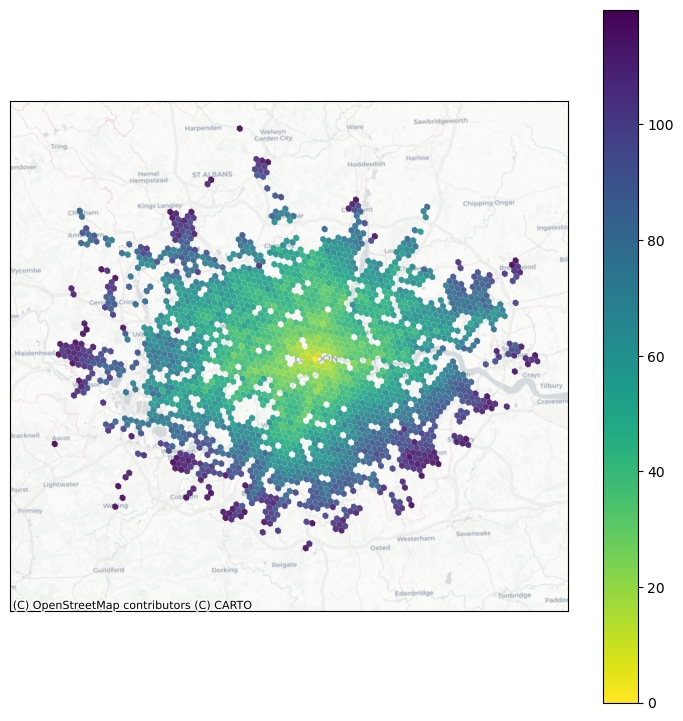

In [123]:
fig, ax = plt.subplots(figsize=(9,9))

# hidden axes

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# setting axis limits

ax.set_xlim(485233.3713651899, 566886.0492240164)
ax.set_ylim(143482.52218441197, 218257.5080728331)

# map data and style

hex_london_res8[    
hex_london_res8['traveltime_to_CX'] < 120 #!= hex_london_res8['traveltime_to_CX'].max()
].plot(
    
    ax=ax,
    alpha=0.9,
    edgecolor=None, 
    column='traveltime_to_CX',
    cmap='viridis_r',
    # categorical=True,
    legend=True, 

)

# basemap

cx.add_basemap(ax, crs=bua_london.crs, source=cx.providers.CartoDB.Positron)

# getting axis limits

# display(ax.get_xlim())
# display(ax.get_ylim())

plt.show()

In [121]:
# printing the full time extent used to run this code in a Intel Core i7-7500U CPU @ 2.70 GHz 2.90 GHz

end = time.time()
print(f'{(end - code_start)/60} min')
winsound.PlaySound('sad_horn.wav', winsound.SND_FILENAME)

87.57464930216472 min
